In [1]:
import pandas as pd
import numpy as np

## Modelos Puerto de Newark:

In [2]:
newark_data = pd.read_csv('../sources/newark_data.csv')

In [9]:
newark_data_input = newark_data.loc[:,['Date','Empty Exports','Loaded Exports','Empty Imports','Loaded Imports','Total TEUs', 'Total Imports', 'Total Exports','Ratio_Cocaine']]
newark_data_input_corr = newark_data_input[['Empty Exports','Loaded Exports','Empty Imports','Loaded Imports','Total TEUs', 'Total Imports', 'Total Exports','Ratio_Cocaine']]

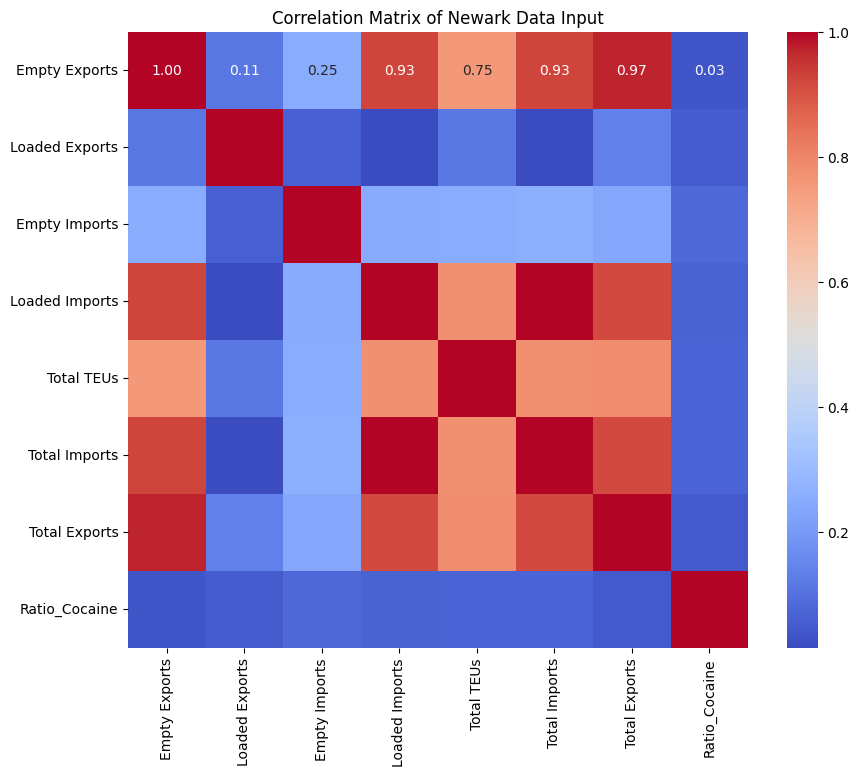

In [10]:
import seaborn as sns

import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = newark_data_input_corr.corr().abs()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Newark Data Input')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor


In [ ]:

X = newark_data_input.drop('Ratio_Cocaine', axis=1)
y = newark_data_input['Ratio_Cocaine']

# Opcion A: Division como train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Create a RandomForestRegressor model
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model to the training data
rf_regressor.fit(X_train, y_train)

In [ ]:
# Evaluate the model on the training data
y_train_pred = rf_regressor.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

print(f'Training MSE: {train_mse}')
print(f'Training R2: {train_r2}')

# Predict on the test data
y_test_pred = rf_regressor.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f'Test MSE: {test_mse}')
print(f'Test R2: {test_r2}')

In [ ]:
# Define the features and target variable
X_filtered = newark_data_input.drop(['Date', 'Ratio_Cocaine'], axis=1)
y_filtered = newark_data_input['Ratio_Cocaine']

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Initialize the RandomForestRegressor
rf_regressor_ts = RandomForestRegressor(n_estimators=100, random_state=42)

# Perform cross-validation
for train_index, test_index in tscv.split(X_filtered):
    X_train_ts, X_test_ts = X_filtered.iloc[train_index], X_filtered.iloc[test_index]
    y_train_ts, y_test_ts = y_filtered.iloc[train_index], y_filtered.iloc[test_index]
    
    # Fit the model
    rf_regressor_ts.fit(X_train_ts, y_train_ts)
    
    # Predict on the test data
    y_test_pred_ts = rf_regressor_ts.predict(X_test_ts)
    
    # Evaluate the model
    test_mse_ts = mean_squared_error(y_test_ts, y_test_pred_ts)
    test_r2_ts = r2_score(y_test_ts, y_test_pred_ts)
    
    print(f'Test MSE: {test_mse_ts}')
    print(f'Test R2: {test_r2_ts}')

## Modelos Puerto de Everglades:

In [11]:
everglades_data = pd.read_csv('../sources/everglades_data.csv')

In [12]:
everglades_data_input = everglades_data.loc[:,['Date','Empty Exports','Loaded Exports','Empty Imports','Loaded Imports','Total TEUs', 'Total Imports', 'Total Exports','Sum_of_Counts']]
everglades_data_input_corr = everglades_data_input[['Empty Exports','Loaded Exports','Empty Imports','Loaded Imports','Total TEUs', 'Total Imports', 'Total Exports','Sum_of_Counts']]

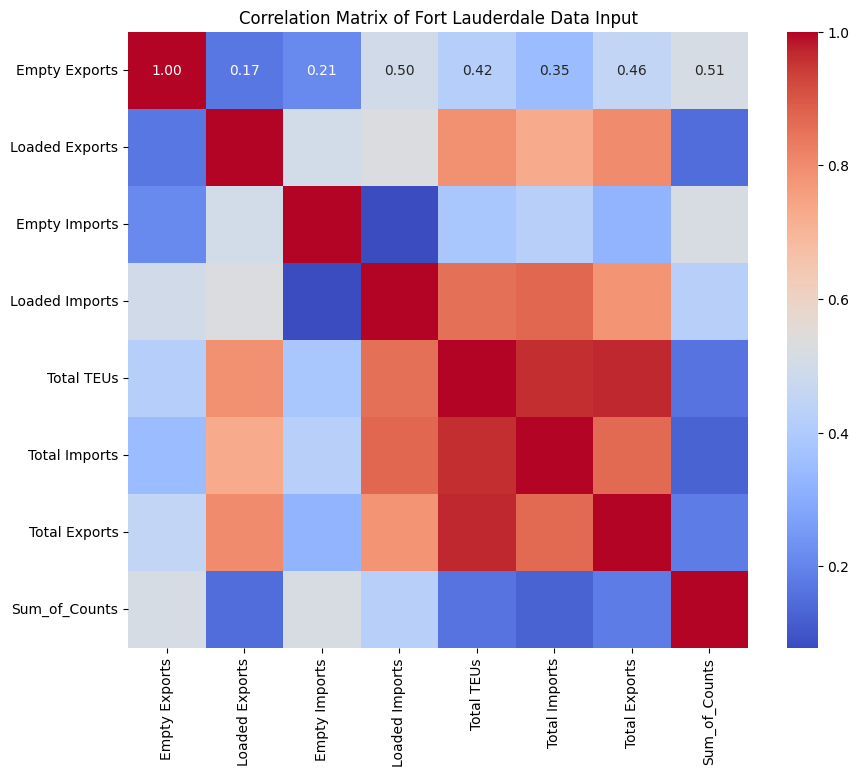

In [14]:
import seaborn as sns

import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = everglades_data_input_corr.corr().abs()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Fort Lauderdale Data Input')
plt.show()

In [ ]:
# Define the features and target variable
X_filtered = everglades_data_input.drop(['Date', 'Sum_of_Counts'], axis=1)
y_filtered = everglades_data_input['Sum_of_Counts']

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Initialize the RandomForestRegressor
rf_regressor_ts = RandomForestRegressor(n_estimators=100, random_state=42)

# Perform cross-validation
for train_index, test_index in tscv.split(X_filtered):
    X_train_ts, X_test_ts = X_filtered.iloc[train_index], X_filtered.iloc[test_index]
    y_train_ts, y_test_ts = y_filtered.iloc[train_index], y_filtered.iloc[test_index]
    
    # Fit the model
    rf_regressor_ts.fit(X_train_ts, y_train_ts)
    
    # Predict on the test data
    y_test_pred_ts = rf_regressor_ts.predict(X_test_ts)
    
    # Evaluate the model
    test_mse_ts = mean_squared_error(y_test_ts, y_test_pred_ts)
    test_r2_ts = r2_score(y_test_ts, y_test_pred_ts)
    
    print(f'Test MSE: {test_mse_ts}')
    print(f'Test R2: {test_r2_ts}')

In [ ]:
# Con train/test split:
X = everglades_data_input.drop(['Sum_of_Counts','Date'], axis=1)
y = everglades_data_input['Sum_of_Counts']

# Opcion A: Division como train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a RandomForestRegressor model
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model to the training data
rf_regressor.fit(X_train, y_train)

In [ ]:
# Evaluate the model on the training data
y_train_pred = rf_regressor.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

print(f'Training MSE: {train_mse}')
print(f'Training R2: {train_r2}')

# Predict on the test data
y_test_pred = rf_regressor.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f'Test MSE: {test_mse}')
print(f'Test R2: {test_r2}')